In [1]:
%matplotlib inline

In [77]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import gc

# from sklearn import svm, decomposition
from preprocess import remove_high_freq, whitening, from_cifar_to_np, from_submit_to_np
from plot import imshow
from util import trainNN, cal_accuracy, cal_class_accuracy, get_submit_result, export_to_file, print_accracy
from models import *

use_pca = False
use_forieum = False
export_csv = True
csv_name = 'res_resnet_big_batch_1500_250_epoch_add_100.csv'
BATCH_SIZE = 32

In [78]:
print('==> Preparing data..')
transform_train = transforms.Compose(
    [
#          transforms.RandomRotation(5),
         transforms.RandomCrop(32, padding=4),
#          transforms.RandomResizedCrop(32),
         transforms.RandomHorizontalFlip(),
#          transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
#          transforms.RandomRotation(5),
         transforms.RandomCrop(32, padding=4),
#          transforms.RandomResizedCrop(32),
         transforms.RandomHorizontalFlip(),
#          transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]) 

transform_test = transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]) 


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=0)
submitdata = np.load("./test/y_test.npy").astype(np.uint8)

submit_images = [ transform_test(img) for img in submitdata]

submitloader = torch.utils.data.DataLoader(submit_images, batch_size=1500,
                                          shuffle=False, num_workers=2)

# class MyDataset(torch.utils.data.Dataset):
#     def __init__(self,testdata,transform):
#         # show image
#         self.testdata=testdata
#         self.len = testdata.shape[0]
#         self.transform=transform

#     def __getitem__(self, index):
#         img = self.transform(self.testdata[index])
#         return img

#     def __len__(self):
#         return self.len

# submitset = MyDataset(testdata=submitdata, transform=transform_test)
# submitloader = torch.utils.data.DataLoader(submitset, batch_size=1, shuffle=False, num_workers=0)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainX, trainY = from_cifar_to_np(trainloader)
if not use_forieum:
    trainX = np.reshape(trainX, (50000, 3072))
print(trainX.shape)
print(trainY.shape)

(50000, 3072)
(50000,)


In [5]:
testX, testY = from_cifar_to_np(testloader)
if not use_forieum:
    testX = np.reshape(testX, (10000, 3072))
print(testX.shape)
print(testY.shape)

(10000, 3072)
(10000,)


In [6]:
submitX = from_submit_to_np(submitloader)
if not use_forieum:
    submitX = np.reshape(submitX, (12000, 3072))
print(submitX.shape)

(12000, 3072)


In [7]:
# Assume that we are on a CUDA machine, then this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


torch.Size([128, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship truck  ship   cat  bird  ship truck   dog


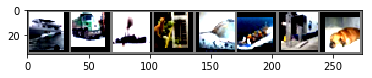

In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print(images)
print(images.size())

# show images in a batch, which contains 8 images
imshow(torchvision.utils.make_grid(images[0:8]))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [9]:
print('==> Building model..')
# net = SeventySevenNet()
net = ResNet18()
# net = LargeNet()
# net = VGG('VGG19')
# net = WeakerNet21()
net = net.to(device)
criterion = nn.CrossEntropyLoss()

==> Building model..


In [10]:
for i in range(30): 
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
    trainNN(net, trainloader, optimizer, criterion,  5)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0200016
[1,   200] double loss: 0.0153029
[1,   300] double loss: 0.0141716
[2,   100] double loss: 0.0128416
[2,   200] double loss: 0.0122592
[2,   300] double loss: 0.0118662
[3,   100] double loss: 0.0108873
[3,   200] double loss: 0.0103940
[3,   300] double loss: 0.0100172
[4,   100] double loss: 0.0091937
[4,   200] double loss: 0.0086274
[4,   300] double loss: 0.0081843
[5,   100] double loss: 0.0076040
[5,   200] double loss: 0.0072500
[5,   300] double loss: 0.0070379
Accuracy of the network on the 10000 test images: 70.320000 %
Accuracy of the network on the train images: 70.746000 %
Training starts
[1,   100] double loss: 0.0064197
[1,   200] double loss: 0.0060198
[1,   300] double loss: 0.0058620
[2,   100] double loss: 0.0053520
[2,   200] double loss: 0.0053286
[2,   300] double loss: 0.0051709
[3,   100] double loss: 0.0048555
[3,   200] double loss: 0.0047750
[3,   300] double loss: 0.0046335
[4,   100] double loss: 0.0042865

[3,   100] double loss: 0.0022612
[3,   200] double loss: 0.0023899
[3,   300] double loss: 0.0024719
[4,   100] double loss: 0.0023492
[4,   200] double loss: 0.0023375
[4,   300] double loss: 0.0024710
[5,   100] double loss: 0.0022191
[5,   200] double loss: 0.0023888
[5,   300] double loss: 0.0025054
Accuracy of the network on the 10000 test images: 86.220000 %
Accuracy of the network on the train images: 90.554000 %
Training starts
[1,   100] double loss: 0.0021950
[1,   200] double loss: 0.0024343
[1,   300] double loss: 0.0024353
[2,   100] double loss: 0.0022593
[2,   200] double loss: 0.0023395
[2,   300] double loss: 0.0024688
[3,   100] double loss: 0.0023734
[3,   200] double loss: 0.0024626
[3,   300] double loss: 0.0024146
[4,   100] double loss: 0.0022976
[4,   200] double loss: 0.0023045
[4,   300] double loss: 0.0025852
[5,   100] double loss: 0.0023120
[5,   200] double loss: 0.0024571
[5,   300] double loss: 0.0024208
Accuracy of the network on the 10000 test images:

In [11]:
for i in range(20): 
    optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
    trainNN(net, trainloader, optimizer, criterion,  5)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0015891
[1,   200] double loss: 0.0012107
[1,   300] double loss: 0.0011304
[2,   100] double loss: 0.0009209
[2,   200] double loss: 0.0008855
[2,   300] double loss: 0.0008535
[3,   100] double loss: 0.0007214
[3,   200] double loss: 0.0007372
[3,   300] double loss: 0.0007193
[4,   100] double loss: 0.0005902
[4,   200] double loss: 0.0006287
[4,   300] double loss: 0.0005814
[5,   100] double loss: 0.0005247
[5,   200] double loss: 0.0005410
[5,   300] double loss: 0.0005705
Accuracy of the network on the 10000 test images: 92.080000 %
Accuracy of the network on the train images: 98.060000 %
Training starts
[1,   100] double loss: 0.0005087
[1,   200] double loss: 0.0004564
[1,   300] double loss: 0.0005060
[2,   100] double loss: 0.0004410
[2,   200] double loss: 0.0004439
[2,   300] double loss: 0.0004527
[3,   100] double loss: 0.0003737
[3,   200] double loss: 0.0003711
[3,   300] double loss: 0.0004016
[4,   100] double loss: 0.0003393

In [12]:
params = list(net.parameters())
print(len(params))

62


In [13]:
cal_class_accuracy(net, testloader)

Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 78 %
Accuracy of   cat : 76 %
Accuracy of  deer : 87 %
Accuracy of   dog : 84 %
Accuracy of  frog : 92 %
Accuracy of horse : 100 %
Accuracy of  ship : 89 %
Accuracy of truck : 82 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


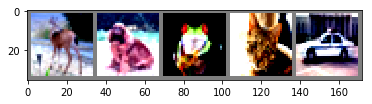

In [14]:
images = submit_images[2100:2105]
imshow(torchvision.utils.make_grid(images))

(3000, 3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


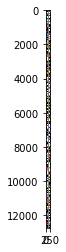

In [15]:
dataiter = iter(submitloader)
images = dataiter.next()
print(np.array(images).shape)
imshow(torchvision.utils.make_grid(images))

In [71]:
gc.collect()

223

In [72]:
# res_labels = get_submit_result(net, submitloader)
res_per = []
with torch.no_grad():
    for i, data in enumerate(submitloader, 0):
        inputs = data.to(device)
        # forward + backward + optimize
        outputs = net(inputs)
        for o in outputs:
            res_per.append(o)
res_labels = [int(torch.max(t,0)[1]) for t in res_per]


RuntimeError: CUDA out of memory. Tried to allocate 382.00 MiB (GPU 0; 4.00 GiB total capacity; 1.66 GiB already allocated; 74.80 MiB free; 1.19 GiB cached)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane plane truck plane plane plane  ship plane plane plane plane plane plane plane  ship plane plane plane plane plane truck plane plane plane plane plane plane plane plane truck


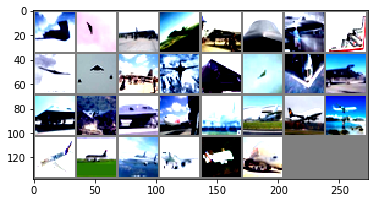

In [59]:
images = submit_images[0:30]
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[res_labels[j]] for j in range(0, 30)))

In [60]:
if export_csv:
    export_to_file(csv_name, res_labels)

In [75]:
for i in range(2): 
    optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-3)
    trainNN(net, trainloader, optimizer, criterion,  5)
    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   100] double loss: 0.0002103
[1,   200] double loss: 0.0001714
[1,   300] double loss: 0.0001436
[2,   100] double loss: 0.0000891
[2,   200] double loss: 0.0000968
[2,   300] double loss: 0.0000898
[3,   100] double loss: 0.0000735
[3,   200] double loss: 0.0000786
[3,   300] double loss: 0.0000756
[4,   100] double loss: 0.0000674
[4,   200] double loss: 0.0000728
[4,   300] double loss: 0.0000696
[5,   100] double loss: 0.0000692
[5,   200] double loss: 0.0000634
[5,   300] double loss: 0.0000656
Accuracy of the network on the 10000 test images: 92.920000 %
Accuracy of the network on the train images: 99.906000 %
Training starts
[1,   100] double loss: 0.0000691
[1,   200] double loss: 0.0000754
[1,   300] double loss: 0.0000745
[2,   100] double loss: 0.0000712
[2,   200] double loss: 0.0000752
[2,   300] double loss: 0.0000838
[3,   100] double loss: 0.0000728
[3,   200] double loss: 0.0000710
[3,   300] double loss: 0.0000771
[4,   100] double loss: 0.0000853

In [79]:
params = list(net.parameters())
print(len(params))
cal_class_accuracy(net, testloader)
gc.collect()

res_per2 = []
with torch.no_grad():
    for i, data in enumerate(submitloader, 0):
        inputs = data.to(device)
        # forward + backward + optimize
        outputs = net(inputs)
        for o in outputs:
            res_per2.append(o)
res_labels2 = [int(torch.max(t,0)[1]) for t in res_per2]

62
Accuracy of plane : 97 %
Accuracy of   car : 100 %
Accuracy of  bird : 84 %
Accuracy of   cat : 83 %
Accuracy of  deer : 91 %
Accuracy of   dog : 93 %
Accuracy of  frog : 96 %
Accuracy of horse : 100 %
Accuracy of  ship : 93 %
Accuracy of truck : 86 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane plane truck plane plane plane  ship plane plane plane plane plane plane plane  ship plane plane plane plane plane truck plane plane plane plane plane plane plane plane truck


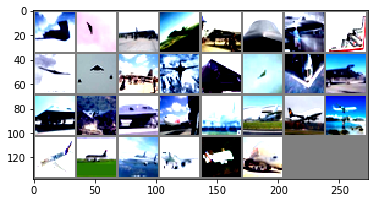

In [83]:
images = submit_images[0:30]
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[res_labels[j]] for j in range(0, 30)))

In [82]:
if export_csv:
    export_to_file(csv_name, res_labels2) 

In [85]:
import os
best_accuracy = 0.0
epoch = 260
current_accuracy = cal_accuracy(net, testloader)
if current_accuracy>best_accuracy: 
    print('Saving...')
    state = {
        'net': net.state_dict(),
        'acc': current_accuracy,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/resnet_ckpt.pth')
    best_accuracy = current_accuracy

Saving...
